In [1]:
#!pip list
#!python --version

In [5]:
'''
IMPORT DEPENDANCIES
'''
import tensorflow as tf
from keras.applications import ResNet50
from keras.layers import Input, Concatenate, Conv2D, GlobalAveragePooling2D, Dense, Flatten, MaxPooling2D, MaxPool2D
from keras.models import Sequential, load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import Callback, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import os
import kaggle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import IPython
import tensorflow as tf
print("TensorFlow Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices("GPU"))

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)


TensorFlow Version: 2.10.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
'''
DOWNLOAD DATASET FROM KAGGLE AND STORE LOCALLY
'''

# Function to download the dataset
def Download_dataset(target_dir, dataset):
    
    # Check if the target folder already exists
    if not os.path.exists(target_dir):
        os.makedirs(target_dir) # Create the target folder if it doesn't exist

    dataset_directory = os.path.join(target_dir, dataset)

    # Check if the dataset directory already exists in the download path
    if not os.path.exists(dataset_directory):
        # Dataset doesn't exist, so proceed with the download
        kaggle.api.dataset_download_files(dataset, path=target_directory, unzip=True)
    else:
        print("Dataset is already downloaded. Skipping the download.")


dataset_name = "praveengovi/coronahack-chest-xraydataset" # Define the dataset name and the directory you want to check in

current_dir = os.getcwd()  # Starts the download path in the current working directory
target_folder = "Datasets"  # Specify the name of the target folder

target_directory = os.path.join(current_dir, target_folder)

#Download_dataset(target_directory, dataset_name)

In [11]:
'''
RETRIEVING IMAGES FROM FOLDERS AND SORTING DATA INTO X, Y : TRAIN, TEST
'''
target_size = (224, 224)  # Define target size for image resizing

# Function to order to arrays so each image corresponds to its correct label
def order_images_and_labels(folder, dataframe):
    images = [] # New image array
    labels = [] # New Label array

    for index, row in dataframe.iterrows():
        image_path = os.path.join(folder, row["X_ray_image_name"])
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) # Assigns image the array of the image 
        img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB so it has 3 channels
        img_rgb = cv2.resize(img_rgb, target_size)  # Resize the image to the target size

        label = row["Label"] # Takes the name of the correct label for the image

        if img is not None:
            labels.append(label)
            images.append(img_rgb)

    return(np.array(images), np.array(labels)) # Return and Convert to a NumPy array

def order_fracture_images_and_labels(folder):
    images = []
    labels = []

    # Iterate through fractured and not_fractured subfolders
    for label in ['fractured', 'not_fractured']:
        label_folder = os.path.join(folder, label)
        if not os.path.exists(label_folder):
            continue

        # Iterate through image files in the subfolder
        for image_file in os.listdir(label_folder):
            image_path = os.path.join(label_folder, image_file)
            img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Load image in grayscale mode
            img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)  # Convert grayscale to RGB so it has 3 channels
            img_rgb = cv2.resize(img_rgb, target_size)  # Resize the image to the target size

            # Preprocess the image as needed (e.g., resize)
            # img = cv2.resize(img, target_size)

            # Append the image to the images array
            images.append(img_rgb)
            labels.append(label)

    return np.array(images), np.array(labels)  # Return as NumPy arrays


# Function to plot the image with its correct output
def plot_sample(X, Y ,index):
    plt.figure(figsize=(20,5))
    plt.imshow(X[index], cmap=plt.cm.bone)
    plt.title([Y[index]])

dataset_name = "Coronahack-Chest-XRay-Dataset"
dataset_directory = os.path.join(current_dir, "Datasets")
PneumoniaDatasets = os.path.join(dataset_directory, dataset_name, dataset_name)
FractureDatasets = os.path.join(dataset_directory,"Fractures_Dataset")

# Pneumonia Dataset Handling (Sort images and respective labels in array)
train_data_path = os.path.join(PneumoniaDatasets, "train")  # Folder for train images
test_data_path = os.path.join(PneumoniaDatasets, "test")    # Folder for test images

metadata_src = os.path.join(dataset_directory, "Chest_xray_Corona_Metadata.csv") # Defines source destination for Pneumonia csv file
metadata = pd.read_csv(metadata_src) # Creates a dataframe from csv file
unique_labels = list(metadata.Label.unique()) # Gets the different labels that are classified ("Pneumonia and normal")
PneumoniaTrain_data = metadata[metadata.Dataset_type == "TRAIN"] # Splits dataframe data labelled train
PneumoniaTest_data = metadata[metadata["Dataset_type"] == "TEST"] # Split dataframe data labelled test
(PneumoniaX_train, PneumoniaY_train) = order_images_and_labels(train_data_path, PneumoniaTrain_data)  # Creates an numpy array for images and associated labels for training set
(PneumoniaX_test, PneumoniaY_test) = order_images_and_labels(test_data_path, PneumoniaTest_data) # Creates an numpy array for images and associated labels for training set

#Fracture Dataset Handling (Sort images and respective labels in array)
FractureTrain_data = os.path.join(FractureDatasets, "train")
FractureTest_data = os.path.join(FractureDatasets, "test")
(FractureX_train, FractureY_train) = order_fracture_images_and_labels(FractureTrain_data)
(FractureX_test, FractureY_test) = order_fracture_images_and_labels(FractureTest_data)


In [14]:
'''
COMBINE TRAIN/TEST DATA, AUGMENT DATA AND SORT DATA INTO TRAINING, VALIDATION AND TEST SETS 
'''

# Combine data
X_Values = np.concatenate((PneumoniaX_train, PneumoniaX_test, FractureX_train, FractureX_test))
Y_Values = np.concatenate((PneumoniaY_train, PneumoniaY_test, FractureY_train, FractureY_test))

# Normalise the images so the pixel values appear bwtween 0 and 1
X_Combined = X_Values/255
Y_Combined = Y_Values/255

class set_info():
    def __init__(self, X, Y, description):
        self.total_img = X.shape[0] # Number of images as each is represented by pixel arrays
        self.norm_num = np.sum(Y == 0) # Number of normal images in set
        self.pneumonia_num = self.total_img - self.norm_num # Number of pneumonia images in set
        self.set_type = description

    def print_size(self):
        return print("Size of", self.set_type, "set:", self.total_img)

    def print_split(self):
        return print(self.set_type, "set normal/pneumonia split:", self.norm_num, "/", self.pneumonia_num)

'''
# Apply Augmentation
data_gen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rescale=1./255  # Rescale pixel values to [0, 1]
)
# Flow training images in batches with data augmentation
augmented_train_generator = data_gen.flow(X_train, Y_train, batch_size=10)

# Flow validation images with data augmentation
validation_generator = data_gen.flow(X_test, Y_test, batch_size=10)
'''

# Split combined data into training(70%), validation(21%), and test(9%)
X_Train, X_temp, Y_Train, Y_temp = train_test_split(X_Combined, Y_Combined, test_size=0.3, random_state=42) # Splits combined 70-30 into train and others
X_Val, X_Test, Y_Val, Y_Test = train_test_split(X_temp, Y_temp, test_size=0.3, random_state=42) # Splits others 70-30 into Validation and test

train_info = set_info(X_Train, Y_Train, "Training")
val_info = set_info(X_Val, Y_Val, "Validation")
test_info = set_info(X_Test, Y_Test, "Test")

train_info.print_size()
val_info.print_size()
test_info.print_size()

train_info.print_split()
val_info.print_split()
test_info.print_split()


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 4 dimension(s) and the array at index 2 has 3 dimension(s)

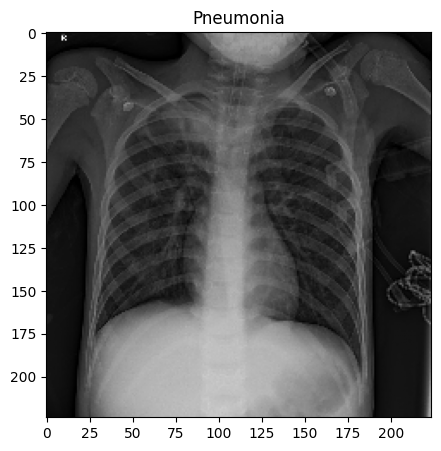

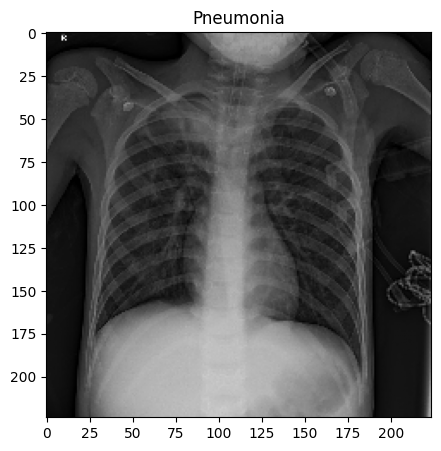

In [6]:
plot_sample(X_train, Y_train, 1341)
plot_sample(X_Combined, Y_Combined, 1341)

In [7]:
'''
IMPORT, BUILD AND COMPLIE THE RESNET50 MODEL
'''
#Building and training settings
lr = 0.0004
Batch_Size = 16
epochs = 30

modified_model = Sequential()
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

modified_model.add(base_model)
modified_model.add(Flatten())
modified_model.add(Dense(512, activation="relu"))

# Add the final dense layer with 1 unit for Binary classification
modified_model.add(Dense(1, activation="sigmoid"))

for layer in base_model.layers:
    layer.trainable = False
    
modified_model.summary()

#Compile the model
Myoptimizer = tf.keras.optimizers.Adam(learning_rate=lr)
modified_model.compile(optimizer=Myoptimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 512)               51380736  
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                                 
Total params: 74,968,961
Trainable params: 51,381,249
Non-trainable params: 23,587,712
_________________________________________________________________


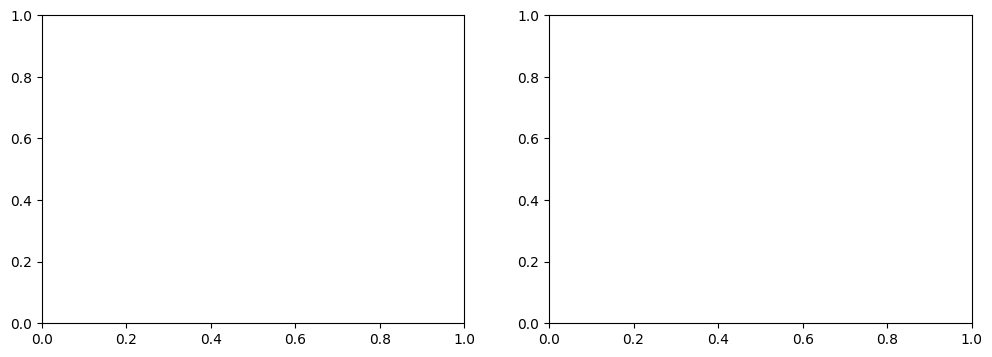

In [8]:
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self, initial_lr, batch_size):
        super().__init__()
        self.train_losses = []  # Train loss
        self.val_losses = []    # Validation loss
        self.train_accuracy = [] # Train accuracy
        self.val_accuracy = [] # Validation accuracy
        self.fig, (self.ax1, self.ax2) = plt.subplots(1, 2, figsize=(12,4))
        self.initial_lr = initial_lr
        self.batch_size = batch_size

    def on_train_begin(self, logs=None):
        self.lr = self.initial_lr


    def on_epoch_end(self, epoch, logs={}):
        #Adjust x axis to start from 1 instead of 0
        epoch = epoch + 1

        self.train_losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.train_accuracy.append(logs.get('accuracy'))         # Train accuracy
        self.val_accuracy.append(logs.get('val_accuracy'))      # Validation accuracy

        # Plot loss in the left subplot for loss
        self.ax1.cla()
        self.ax1.plot(range(1, epoch+1), self.train_losses, label="train loss")
        self.ax1.plot(range(1, epoch+1), self.val_losses, label="validation loss")
        self.ax1.set_title(f'Loss\ninitial lr = {self.initial_lr:.1e}, Lr = {self.lr:.1e}, Batch size = {Batch_Size}')
        self.ax1.set_xlabel('Epoch')
        self.ax1.set_ylabel('Loss')
        self.ax1.set_ylim(0, 1)  # Set y-axis limits to show the range from 0 to 1
        self.ax1.legend()

        # Plot accuracy in the right subplot for accuracy
        self.ax2.cla()
        self.ax2.plot(range(1, epoch+1), self.train_accuracy, label="train accuracy")
        self.ax2.plot(range(1, epoch+1), self.val_accuracy, label="validation accuracy")
        self.ax2.set_title(f'Accuracy\ninitial lr = {self.initial_lr:.1e}, Lr = {self.lr:.1e}, Batch size = {Batch_Size}')
        self.ax2.set_xlabel('Epoch')
        self.ax2.set_ylabel('Accuracy')
        self.ax2.set_ylim(0, 1)  # Set y-axis limits to show the range from 0 to 1
        self.ax2.legend()

        IPython.display.clear_output(wait=True)
        IPython.display.display(self.fig)

        # Save the figures
        
        try:
            self.fig.savefig(f"test_model_checkpoint_lr_{self.initial_lr:.1e}/figures_{int(epoch)}.png")
        except Exception as e:
            print('there was an error: ', e)
            
    def on_epoch_begin(self, epoch, logs=None):
        #Update learning rate using the scheduler at begininning of epoch
        self.lr = self.lr_scheduler(epoch)
    
    def lr_scheduler(self, epoch):
        if epoch % 2 == 0 and epoch != 0:
            print("Updating leraning rate to: " , self.lr * 0.2)
            return self.lr * 0.2
        else:
            return self.lr

#Model checkpoint callback
model_checkpoint = ModelCheckpoint(
    filepath=f"test_model_checkpoint_lr_{lr:.1e}/{{epoch}}val_loss_{{val_loss:.4f}}.h5",
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

MyCallback = CustomCallback(lr, Batch_Size)

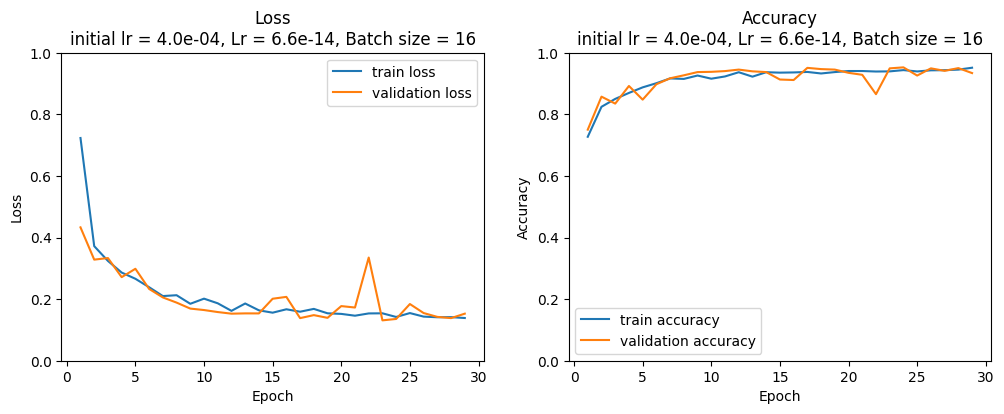

258/258 [==============================] - 10s 39ms/step - loss: 0.1387 - accuracy: 0.9513 - val_loss: 0.1528 - val_accuracy: 0.9339


In [9]:
'''
Train the model
'''
history = modified_model.fit(
    X_Train, 
    Y_Train, 
    steps_per_epoch = len(X_Train) // Batch_Size,
    epochs=epochs, 
    validation_data=(X_Val, Y_Val),
    callbacks=[MyCallback, model_checkpoint]
)

17/17 [==============================] - 2s 87ms/step


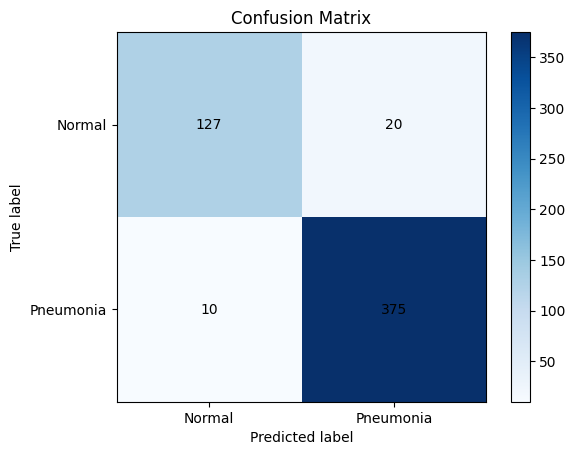

Accuracy:  94.36%


In [10]:
'''
USE THE MODEL TO PREDICT AND CALCULATE AN ACCURACY SCORE BASED ON TEST PREDICTION VS TRUE VALUE
'''
# Plot confusion matrix
def plot_conf_matrix(pred, true):
    conf_matrix = confusion_matrix(true, pred) # Creates and calculates a confusion matrix to show false positives and false negatives using the sklearn function

    # Plot the confusion matrix using Matplotlib with values
    plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar() # Shows how the color respresents values

    classes = ["Normal", "Pneumonia"]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Annotate each cell with the corresponding value
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(conf_matrix[i, j]), horizontalalignment='center', verticalalignment='center')

    #Annotate axis labels
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return plt.show()

# Finds accuracy based on predicted values and true values
def find_accuracy(pred, true):
    correct = 0

    for i in range(0, len(Y_Test)):
        if int(y_pred[i].item()) == Y_Test[i]:
            correct = correct + 1

    return str(round(correct / len(Y_Test) * 100, 2))+"%"

model_path = os.path.join(current_dir, "3model_checkpoint_lr_4.0e-04/9val_loss_0.1375.h5") # Gets path to saved model
loaded_model = load_model(model_path) # Loads saved model

#input_for_prediction = X_Test[4].reshape(1,224,224,3) # For singular prediction of image in test set

# Make predictions on the test set
y_pred_prob = loaded_model.predict(X_Test) # Predicts the probability of detecting Pneumonia
y_pred = np.where(y_pred_prob >= 0.5, 1, 0) # Converts the probability to either a 1 or 0 dependant on probability

plot_conf_matrix(y_pred, Y_Test)
print("Accuracy: ", find_accuracy(y_pred, Y_Test))